# Bottle Cap Color Detection – Model Development Notebook

# **Task 1 — Model Development and Experimentation**
## Machine Learning Engineer Take-Home Test — Ada Mata

### **Objective**
Membangun model Computer Vision real-time untuk mendeteksi tutup botol dengan 3 kategori warna:
- **dark_blue**
- **light_blue**
- **other**

Dataset memiliki format YOLO (bounding box + class), dan semua label sudah disesuaikan ulang.

### **Path Dataset**
- Images: `/content/data/images`
- Labels: `/content/data/labels`

### **Framework**
Menggunakan **YOLOv8 (Ultralytics)** karena:
- Ringan → cocok untuk edge device  
- Optimized untuk inference cepat  
- Arsitektur modern (CSPDarknet + PAN-FPN)

Notebook akan mencakup:
1. Loading dataset  
2. Visualisasi bounding box  
3. Training model  
4. Evaluasi performa  
5. Analisis dataset, bias, dan isu potensial  
6. Perbandingan model & inference speed (tanpa Raspberry Pi)


In [ ]:
!pip install ultralytics opencv-python numpy matplotlib

In [ ]:
# Cell 1: Import Library
import os
import glob
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import yaml

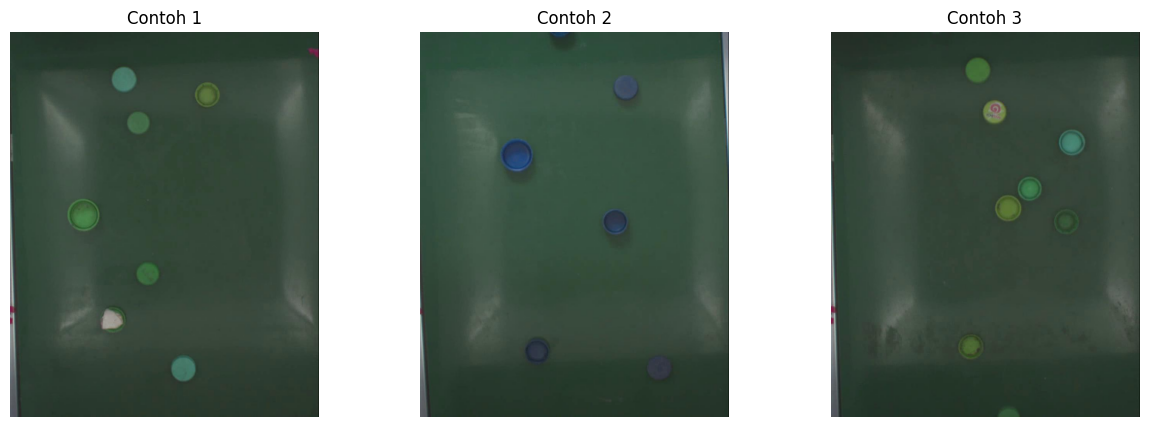

In [ ]:
# =========================================================
# Cell 2: Definisikan path dataset dan tampilkan 3 contoh gambar
IMAGE_PATH = "/content/data/images"
LABEL_PATH = "/content/data/labels"

# Ambil semua file jpg
all_images = glob.glob(os.path.join(IMAGE_PATH, "*.jpg"))

# Tampilkan 3 contoh gambar
plt.figure(figsize=(15,5))
for i, img_file in enumerate(all_images[:3]):
    img = cv2.imread(img_file)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i+1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Contoh {i+1}")
plt.show()


In [ ]:
# Cell 3: Check number of images and labels
import glob

# Filter for only .jpg files in IMAGE_PATH
imgs = glob.glob(os.path.join(IMAGE_PATH, "*.jpg"))
lbls = os.listdir(LABEL_PATH)

print("Total Images:", len(imgs))
print("Total Labels:", len(lbls))

print("\nContoh file:")
print("Image:", [os.path.basename(f) for f in imgs[:5]]) # Print only base names
print("Label:", lbls[:5])

Total Images: 12
Total Labels: 13

Contoh file:
Image: ['raw-250110_dc_s001_b2_3_jpg.rf.b7e78eda7f0a97ef37fe1fc64aeb15b0.jpg', 'raw-250110_dc_s001_b5_5_jpg.rf.891a1b352d81224cc9437af8d9142972.jpg', 'raw-250110_dc_s001_b2_15_jpg.rf.b8dd1e1cd1168aaed842dac3d601b707.jpg', 'raw-250110_dc_s001_b4_2_jpg.rf.709935cb982c08f4115d746a46644516.jpg', 'raw-250110_dc_s001_b4_1_jpg.rf.9962d44451c98fdcc99ca277edd797e8.jpg']
Label: ['raw-250110_dc_s001_b4_1_jpg.rf.9962d44451c98fdcc99ca277edd797e8.txt', '.ipynb_checkpoints', 'raw-250110_dc_s001_b3_3_jpg.rf.e4fb8dbe8bd5215fea8163fd33d59367.txt', 'raw-250110_dc_s001_b2_3_jpg.rf.b7e78eda7f0a97ef37fe1fc64aeb15b0.txt', 'raw-250110_dc_s001_b2_15_jpg.rf.b8dd1e1cd1168aaed842dac3d601b707.txt']


Visualizing: /content/data/images/raw-250110_dc_s001_b2_3_jpg.rf.b7e78eda7f0a97ef37fe1fc64aeb15b0.jpg


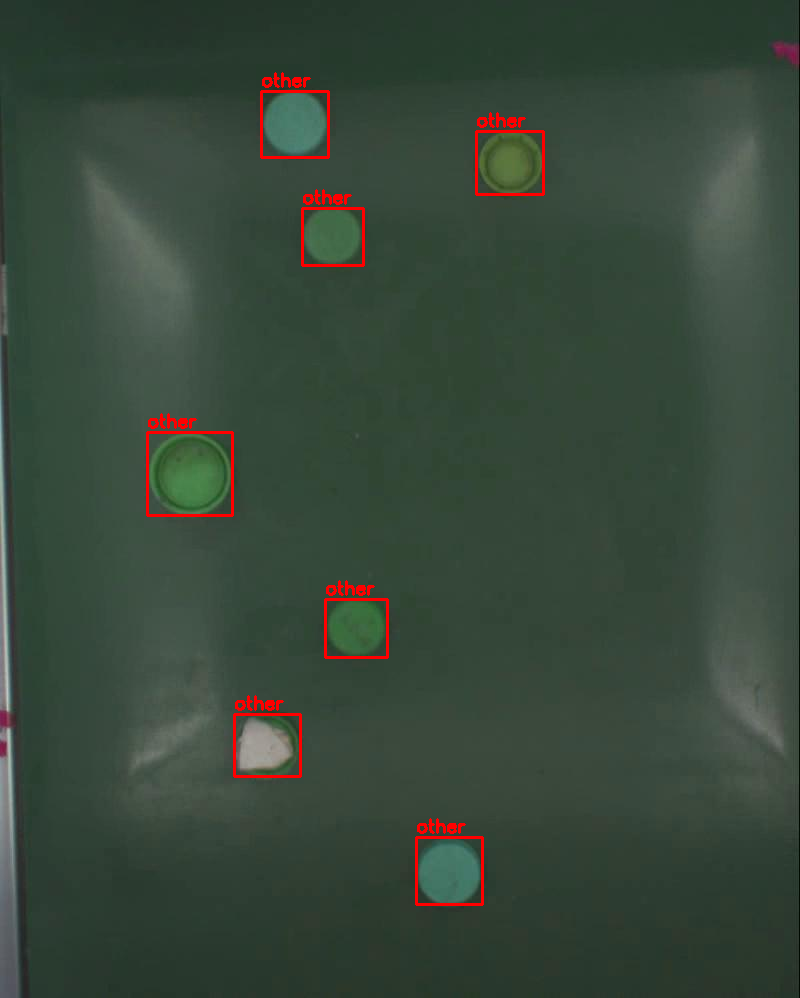

Visualizing: /content/data/images/raw-250110_dc_s001_b5_5_jpg.rf.891a1b352d81224cc9437af8d9142972.jpg


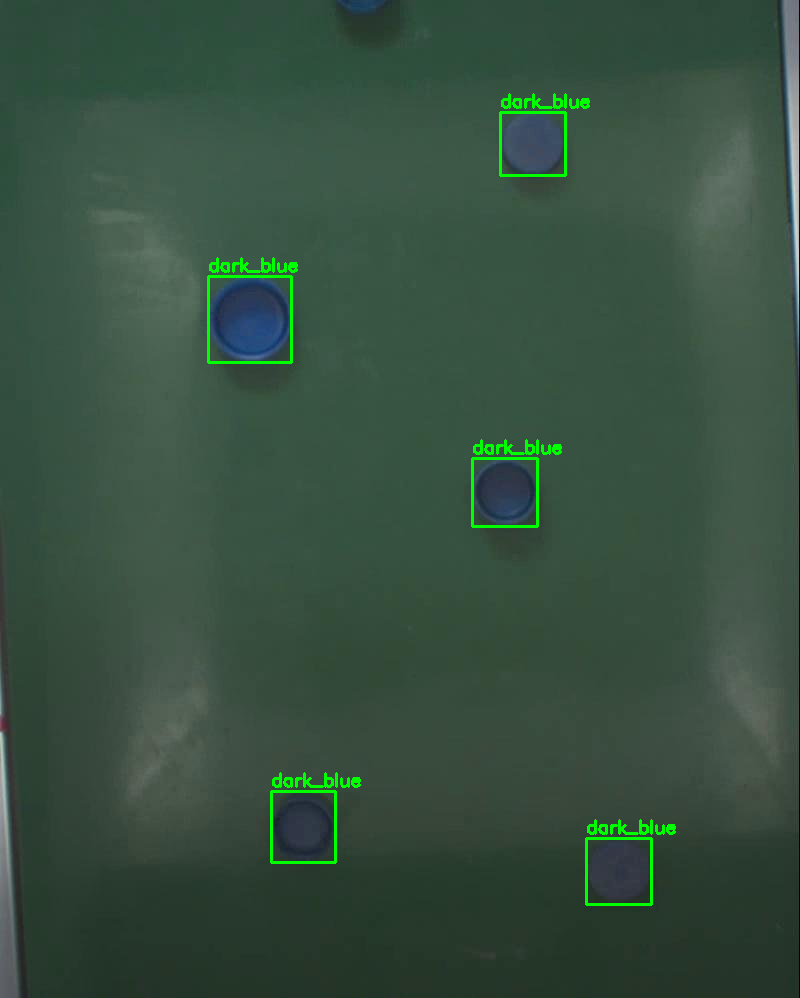

Visualizing: /content/data/images/raw-250110_dc_s001_b2_15_jpg.rf.b8dd1e1cd1168aaed842dac3d601b707.jpg


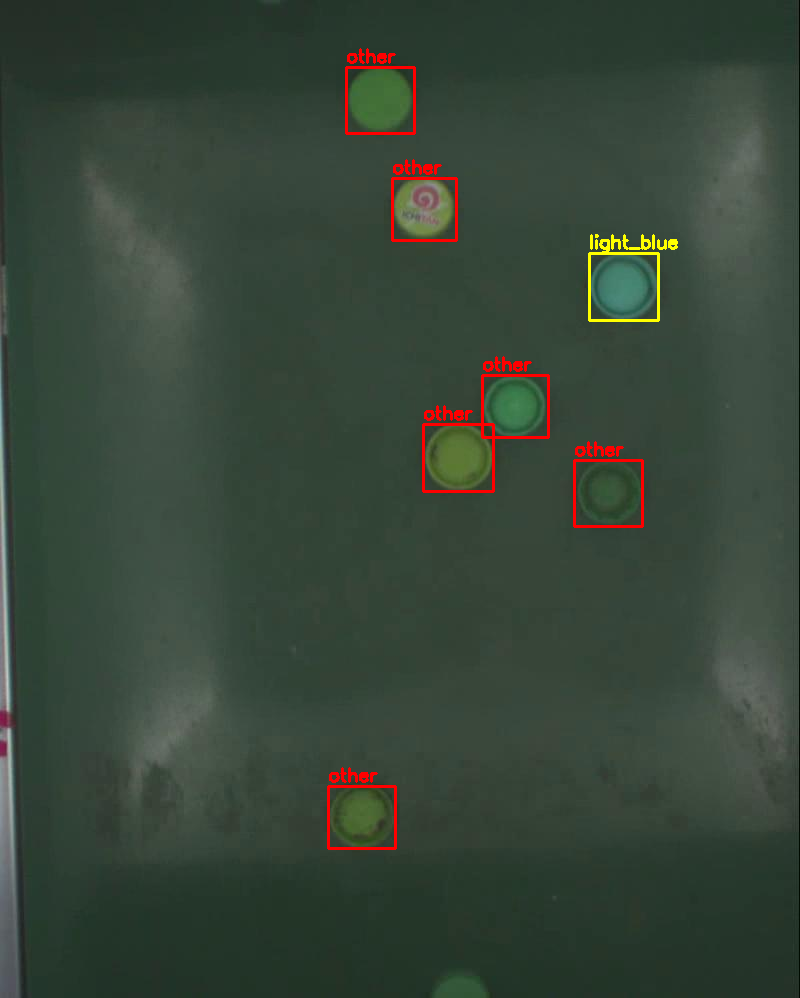

In [ ]:
# Cell 4: Visualize YOLO bounding boxes

def visualize_yolo_bbox(image_path, label_path):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, x, y, bw, bh = map(float, line.strip().split())

        # Convert YOLO format to pixel locations
        cx, cy = int(x * w), int(y * h)
        bw, bh = int(bw * w), int(bh * h)

        x1, y1 = int(cx - bw / 2), int(cy - bh / 2)
        x2, y2 = int(cx + bw / 2), int(cy + bh / 2)

        # Coloring based on class
        if cls == 0:
            color = (0, 255, 0)        # green → dark_blue
            label_name = "dark_blue"
        elif cls == 1:
            color = (0, 255, 255)      # yellow → light_blue
            label_name = "light_blue"
        else:
            color = (0, 0, 255)        # red → other
            label_name = "other"

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label_name, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    cv2_imshow(img)


# Show 3 sample visualizations
for i in range(3):
    img_full_path = all_images[i]
    img_basename = os.path.basename(img_full_path) # Get only the filename
    lbl_basename = img_basename.replace(".jpg", ".txt").replace(".png", ".txt")

    print(f"Visualizing: {img_full_path}")
    visualize_yolo_bbox(
        img_full_path,
        os.path.join(LABEL_PATH, lbl_basename) # Correctly join LABEL_PATH with the base label name
    )

In [ ]:
# Cell 5: Create dataset.yaml dynamically

dataset_yaml = {
    "path": "/content",
    "train": "data/train/images",
    "val": "data/val/images",
    "names": ["dark_blue", "light_blue", "other"]
}

with open("dataset.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)

print(open("dataset.yaml").read())


names:
- dark_blue
- light_blue
- other
path: /content
train: data/train/images
val: data/val/images



In [ ]:
# Cell 6: Train/Val split
import random
import shutil
import os

# Use IMAGE_PATH for listing images, filtering for .jpg files
images = [f for f in os.listdir(IMAGE_PATH) if f.endswith('.jpg')]
random.shuffle(images)

split_idx = int(0.8 * len(images))
train_imgs = images[:split_idx]
val_imgs = images[split_idx:]

# Create folders
for split in ["train", "val"]:
    os.makedirs(f"/content/data/{split}/images", exist_ok=True)
    os.makedirs(f"/content/data/{split}/labels", exist_ok=True)

# Move files
for img in train_imgs:
    shutil.copy(os.path.join(IMAGE_PATH, img), f"/content/data/train/images/{img}")
    label = img.replace(".jpg", ".txt")
    shutil.copy(os.path.join(LABEL_PATH, label), f"/content/data/train/labels/{label}")

for img in val_imgs:
    shutil.copy(os.path.join(IMAGE_PATH, img), f"/content/data/val/images/{img}")
    label = img.replace(".jpg", ".txt")
    shutil.copy(os.path.join(LABEL_PATH, label), f"/content/data/val/labels/{label}")

print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))

Train images: 9
Val images: 3


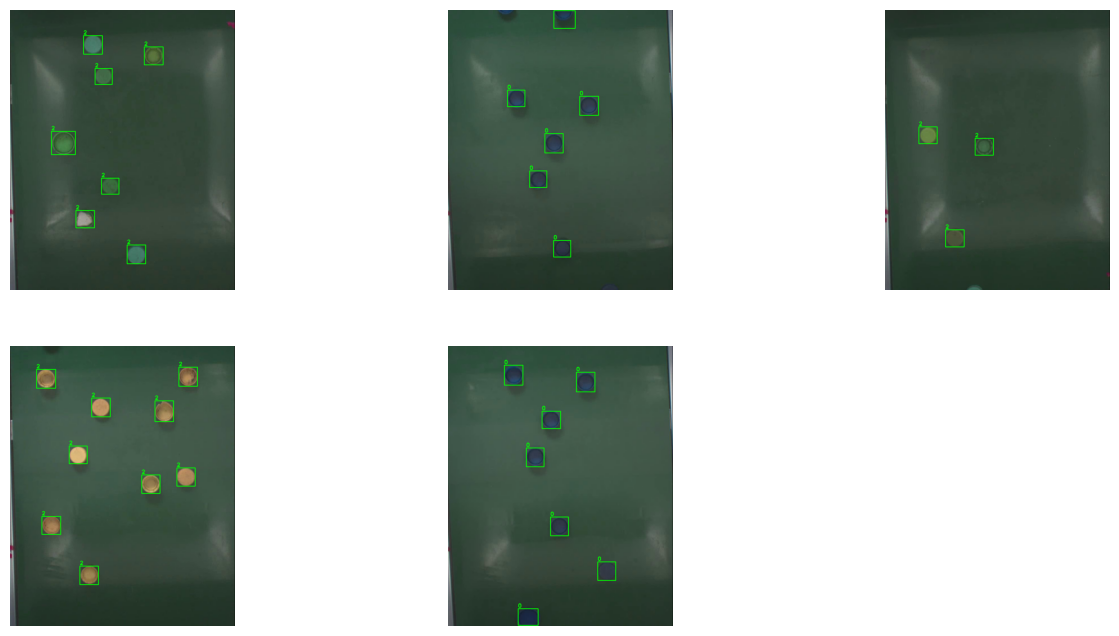

In [ ]:
# Cell 7: Visualize YOLO bounding box for 5 random images

def draw_yolo_bboxes(img_path, label_path):
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    with open(label_path, "r") as f:
        for line in f:
            cls, x, y, w, h = map(float, line.split())
            x1 = int((x - w/2) * img_w)
            y1 = int((y - h/2) * img_h)
            x2 = int((x + w/2) * img_w)
            y2 = int((y + h/2) * img_h)

            color = (0,255,0)
            cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
            cv2.putText(img, str(int(cls)), (x1,y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

sample = random.sample(train_imgs, 5)

plt.figure(figsize=(16,8))
for i, img_file in enumerate(sample):
    img_path = f"/content/data/train/images/{img_file}"
    label_path = f"/content/data/train/labels/{img_file.replace('.jpg','.txt')}"
    img = draw_yolo_bboxes(img_path, label_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()


Train class count: Counter({2: 43, 1: 19, 0: 18})
Val class count: Counter({2: 43, 1: 19, 0: 5})


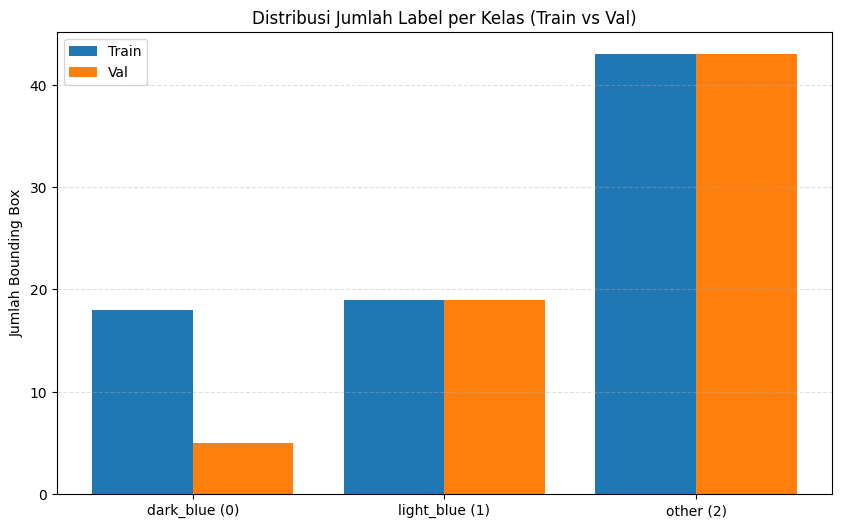

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Function: hitung jumlah class dari folder label
def count_classes(label_dir):
    class_count = Counter()
    for f in os.listdir(label_dir):
        if f.endswith(".txt"):
            with open(os.path.join(label_dir, f), "r") as file:
                for line in file:
                    cls = int(line.split()[0])
                    class_count[cls] += 1
    return class_count

# Hitung class pada train & val
train_class_count = count_classes("/content/data/train/labels")
val_class_count   = count_classes("/content/data/val/labels")

print("Train class count:", train_class_count)
print("Val class count:", val_class_count)

# Siapkan data untuk plot
classes = ["dark_blue (0)", "light_blue (1)", "other (2)"]

train_counts = [
    train_class_count.get(0, 0),
    train_class_count.get(1, 0),
    train_class_count.get(2, 0),
]

val_counts = [
    val_class_count.get(0, 0),
    val_class_count.get(1, 0),
    val_class_count.get(2, 0),
]

x = range(len(classes))

# Plot diagram batang
plt.figure(figsize=(10, 6))
plt.bar([i - 0.2 for i in x], train_counts, width=0.4, label="Train")
plt.bar([i + 0.2 for i in x], val_counts,   width=0.4, label="Val")

plt.xticks(x, classes)
plt.ylabel("Jumlah Bounding Box")
plt.title("Distribusi Jumlah Label per Kelas (Train vs Val)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


In [ ]:
val_label_dir = "/content/data/val/labels"

sample_labels = sorted(os.listdir(val_label_dir))[:5]

for f in sample_labels:
    print("Label:", f)
    print(open(f"{val_label_dir}/{f}", "r").read())
    print("------")


Label: raw-250110_dc_s001_b2_15_jpg.rf.b8dd1e1cd1168aaed842dac3d601b707.txt
2 0.475625 0.10020040080160321 0.085 0.06613226452905811
2 0.760625 0.4939879759519038 0.085 0.06613226452905811
2 0.64375 0.407314629258517 0.0825 0.06312625250501001
2 0.573125 0.4589178356713427 0.0875 0.06713426853707415
2 0.4525 0.8191382765531062 0.08375 0.06312625250501001
2 0.53 0.2094188376753507 0.08 0.06212424849699399
1 0.780625 0.2875751503006012 0.08625 0.06713426853707415
------
Label: raw-250110_dc_s001_b2_1_jpg.rf.19dbb0aa9315d7dcac0c050df8687410.txt
2 0.44125 0.4879759519038076 0.08125 0.06012024048096192
2 0.310625 0.8151302605210421 0.08125 0.061122244488977955
2 0.190625 0.4473947895791583 0.08125 0.06012024048096192
------
Label: raw-250110_dc_s001_b2_3_jpg.rf.b7e78eda7f0a97ef37fe1fc64aeb15b0.txt
2 0.36875 0.12424849699398798 0.08375 0.06613226452905811
2 0.638125 0.16332665330661322 0.08375 0.06412825651302605
2 0.56125 0.872745490981964 0.0825 0.06713426853707415
2 0.445625 0.62925851703

In [ ]:
# Cell 8: Train YOLOv8n model
model = YOLO("yolov8n.pt")  # pretrained COCO

results = model.train(
    data="dataset.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    lr0=0.001,
    patience=20,
)

results


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train16, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretraine

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dfeffce82c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
# Cell 9: Evaluate the trained model (Readable Output)

metrics = model.val()

print("===== MODEL EVALUATION SUMMARY =====\n")

# Precision, Recall, mAP
# Access the scalar value from the numpy array for correct formatting
# Using .mean() assuming metrics.box.p (etc.) are arrays of per-class metrics
print(f"Precision (P):      {metrics.box.p.mean():.4f}")
print(f"Recall (R):         {metrics.box.r.mean():.4f}")
print(f"mAP50:              {metrics.box.map50.mean():.4f}")
print(f"mAP50-95:           {metrics.box.map.mean():.4f}")
print()

# Per-class metrics
print("===== PER-CLASS PERFORMANCE ====")
names = metrics.names
per_class_map = metrics.box.maps   # list mAP per class

for i, name in names.items():
    value = per_class_map[i] if i < len(per_class_map) else None
    if value is not None:
        print(f"- Class {i} ({name}): mAP = {value:.4f}")
    else:
        print(f"- Class {i} ({name}): mAP = N/A")

print("\n===== SPEED (ms) ====")
print(f"Preprocess:         {metrics.speed['preprocess']:.2f} ms")
print(f"Inference:          {metrics.speed['inference']:.2f} ms")
print(f"Postprocess:        {metrics.speed['postprocess']:.2f} ms")

print("\n===== RAW DICT ====")
print(metrics.results_dict)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1171.8±306.3 MB/s, size: 23.2 KB)
val: Scanning /content/data/val/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 7.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 3.3it/s 0.3s
                   all         10         67   0.000361    0.00775    0.00137   0.000683
             dark_blue          1          5          0          0          0          0
            light_blue          4         19          0          0          0          0
                 other          6         43    0.00108     0.0233     0.0041    0.00205
Speed: 0.8ms preprocess, 4.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/runs/detect/val11
===== MODEL EVALUATION 


image 1/1 /content/data/images/raw-250110_dc_s001_b4_1_jpg.rf.9962d44451c98fdcc99ca277edd797e8.jpg: 640x544 5 light_blues, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


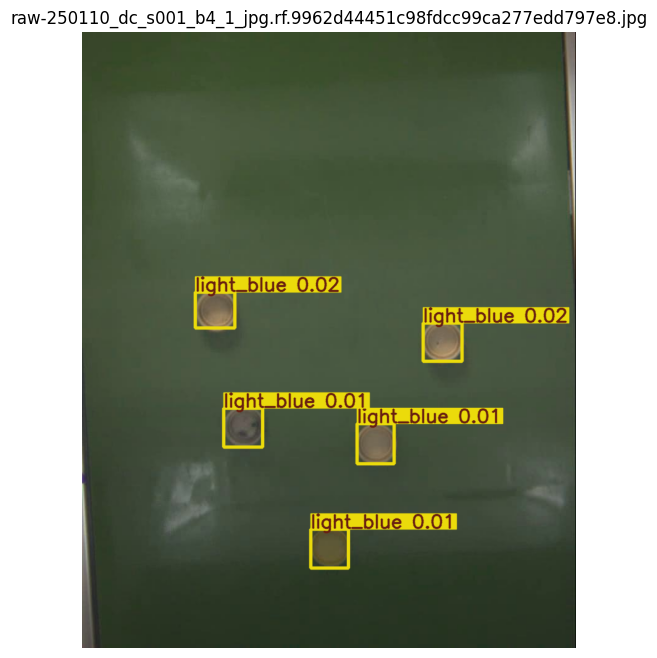


image 1/1 /content/data/images/raw-250110_dc_s001_b3_4_jpg.rf.e68ae93458f4646d304e588e5b59fb12.jpg: 640x544 (no detections), 9.4ms
Speed: 5.7ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


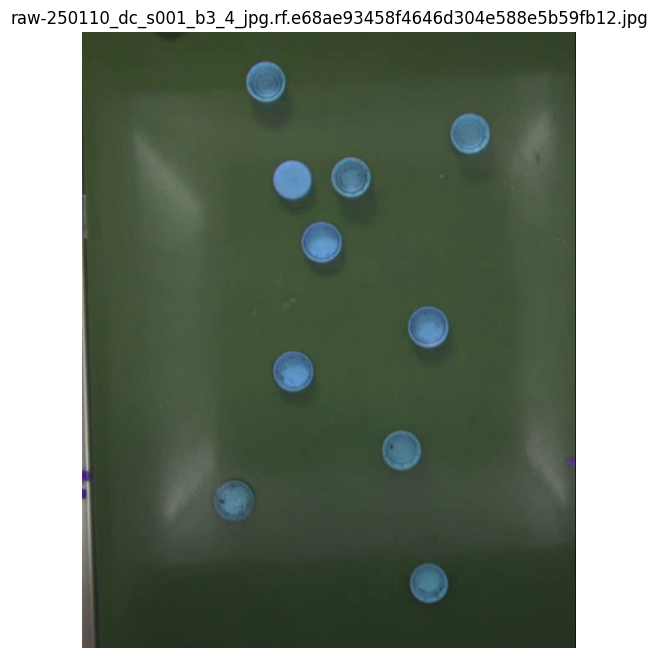


image 1/1 /content/data/images/raw-250110_dc_s001_b5_5_jpg.rf.891a1b352d81224cc9437af8d9142972.jpg: 640x544 3 light_blues, 7.8ms
Speed: 4.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


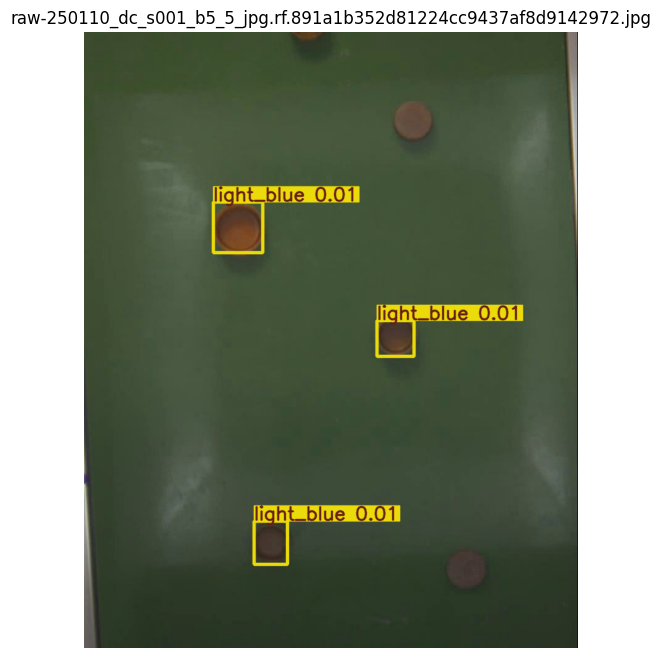

In [ ]:
# Cell 9: Visualize predictions with bounding boxes

import numpy as np
import os # Import os module for path manipulation
# load ulang model untuk memastikan weight benar
model = YOLO("/content/runs/detect/train5/weights/best.pt") # Corrected model path to train5

# val_imgs contains just filenames, we need to join them with IMAGE_PATH
sample_val_images = val_imgs[:5]

for img_filename in sample_val_images:
    img_full_path = os.path.join(IMAGE_PATH, img_filename) # Construct the full path

    results = model.predict(img_full_path, imgsz=640, conf=0.01)

    # annotasi bounding box
    annotated = results[0].plot()

    # tampilkan
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated)
    plt.title(img_filename)
    plt.axis('off')
    plt.show()

In [ ]:
results = model.predict(img_path, imgsz=640, conf=0.05)



image 1/1 /content/data/train/images/raw-250110_dc_s001_b5_3_jpg.rf.85e158cc68dafe2687c56098b7a6d583.jpg: 640x544 (no detections), 11.0ms
Speed: 7.6ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


In [ ]:
# Cell 10: Hitung FPS Inference
import time

test_img = cv2.imread(sample_val_images[0])
start = time.time()
for _ in range(50):  # lakukan 50 kali untuk rata-rata
    _ = model.predict(test_img, imgsz=640)
end = time.time()
fps = 50 / (end - start)
print(f"Inference FPS: {fps:.2f} frame per second")
print(f"Estimasi inference time per frame: {1000/fps:.2f} ms")

WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.12/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.12/dist-packages/ultralytics/assets/bus.jpg: 640x480 (no detections), 7.4ms
image 2/2 /usr/local/lib/python3.12/dist-packages/ultralytics/assets/zidane.jpg: 384x640 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.12/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.12/dist-packages/ultralytics/assets/bus.jpg: 640x480 (no detections), 6.5ms
image 2/2 /usr/local/lib/python3.12/dist-packages/ultralytics/assets/zidane.jpg: 384x640 (no detections), 6.3ms
Speed: 1.7ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.12/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.12/dist-p